# **Business Use Case 2**

## Classification model for identify fraudulent behavior by predicting if a transaction is a fraud or not

The goal of this project is to develop a classification model to accurately identify and predict fraudulent transactions. By analyzing transaction data, the model aims to distinguish between legitimate and fraudulent behavior, thereby enhancing fraud detection and prevention efforts.

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 0. Import Packages

In [2]:
!pip install -r https://raw.githubusercontent.com/phuonganh-38/transaction-analysis-ML/main/requirements.txt

In [3]:
import csv
import os
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### 1.   Load Dataset

In [4]:
#Merge all transactions
data_folder = '/content/drive/My Drive/Transaction Analysis - ML/Transactions'

data = []

for file_csv in os.listdir(data_folder):
    if file_csv.endswith('.csv'):
        file_path = os.path.join(data_folder, file_csv)
        features = pd.read_csv(file_path, sep='|')
        data.append(features)

transactions = pd.concat(data, ignore_index=True)
print(transactions)

                   cc_num      acct_num                         trans_num  \
0           4218196001337  888022315787  91ab12e73ef38206e1121e9648d2408d   
1           4218196001337  888022315787  071553d533a6822a4431c354c434ddcb   
2           4218196001337  888022315787  0cfad38ef15e4749eff68dc83f62c151   
3           4218196001337  888022315787  5782693d7c70f062f258cb30bfa8900f   
4           4218196001337  888022315787  35fd7db657d7e30dd608c37f7798186e   
...                   ...           ...                               ...   
4260899  4413395479406453  929002904576  660c294fe8d540431cc54d25077dc4d1   
4260900  4413395479406453  929002904576  4be02c8434ff59abf1d72f2b8372be0f   
4260901  4413395479406453  929002904576  0b9f714b93b5b1369cdd4fbbc111297d   
4260902  4413395479406453  929002904576  db1d2149e9c939413b0a33b672b496f2   
4260903  4413395479406453  929002904576  fa5d1154d8add5ac13931ab0008df642   

          unix_time       category    amt is_fraud        merchant  merch_l

In [5]:
# Load customers dataset
# Define the function to separate values into columns
def separate_values(file_path):
    with open(file_path, 'r', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter='|')
        columns = next(reader)  # Get the column names from the first row
        data = list(reader)     # Get the remaining rows as data

    return columns, data

# File URL
file_url = '/content/drive/My Drive/Transaction Analysis - ML/customers.csv'

# Call the function to separate values into columns
columns, data = separate_values(file_url)

# Convert data into a DataFrame
customers = pd.DataFrame(data, columns=columns)
customers

,ssn,cc_num,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,acct_num
0,115-04-4507,4218196001337,Jonathan,Johnson,M,863 Lawrence Valleys,Ambler,PA,19002,40.1809,-75.2156,32412,Accounting technician,1959-10-03,888022315787
1,715-55-5575,4351161559407816183,Elaine,Fuller,F,310 Kendra Common Apt. 164,Leland,NC,28451,34.268,-78.0578,27112,Professor Emeritus,1963-06-07,917558277935
2,167-48-5821,4192832764832,Michael,Cameron,M,05641 Robin Port,Cordova,SC,29039,33.4275,-80.8857,4215,International aid/development worker,1973-05-30,718172762479
3,406-83-7518,4238849696532874,Brandon,Williams,M,26916 Carlson Mountain,Birmingham,AL,35242,33.3813,-86.7046,493806,Seismic interpreter,1942-12-26,947268892251
4,697-93-1877,4514627048281480,Lisa,Hernandez,F,809 Burns Creek,Fargo,GA,31631,30.7166,-82.5801,559,Medical laboratory scientific officer,1939-05-22,888335239225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,392-96-7670,30125158904184,Sarah,Martin,F,1666 Jenna Unions,Denver,CO,80236,39.6535,-105.0376,990452,Colour technologist,1993-08-31,201218361926
996,594-17-7993,180047909863618,Erin,Wells,F,444 Alexis Estate Suite 824,Wasco,CA,93280,35.648,-119.4487,27152,Software engineer,1982-05-27,921460407733
997,196-93-1156,4371450311809,Michael,James,M,914 Cassandra Gateway Suite 061,Escondido,CA,92026,33.1605,-117.0978,171802,Agricultural consultant,1999-05-14,499348764671
998,895-65-9304,3519925692476886,Michael,Lewis,M,34141 Katelyn Path,Mattapan,MA,2126,42.2739,-71.0939,25562,Civil Service administrator,1994-02-23,617852071065


In [6]:
# Remove spaces from 'cc_num' and 'acct_num' column
transactions['cc_num'] = transactions['cc_num'].replace(' ', '')
customers['cc_num'] = customers['cc_num'].replace(' ', '')
transactions['acct_num'] = transactions['acct_num'].replace(' ', '')
customers['acct_num'] = customers['acct_num'].replace(' ', '')

#Astype 'cc_num' and 'acct_num'
transactions['cc_num'] = transactions['cc_num'].astype(float)
transactions['acct_num'] = transactions['acct_num'].astype(float)
customers['cc_num'] = customers['cc_num'].astype(float)
customers['acct_num'] = customers['acct_num'].astype(float)

In [7]:
#Merge dataset
df = transactions.merge(customers, how='left', on=['cc_num', 'acct_num'])
df

,cc_num,acct_num,trans_num,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long,...,gender,street,city,state,zip,lat,long,city_pop,job,dob
0,4.218196e+12,8.880223e+11,91ab12e73ef38206e1121e9648d2408d,1558719550,gas_transport,69.12,0,Phillips Group,39.491416,-75.588522,...,M,863 Lawrence Valleys,Ambler,PA,19002,40.1809,-75.2156,32412,Accounting technician,1959-10-03
1,4.218196e+12,8.880223e+11,071553d533a6822a4431c354c434ddcb,1569425519,grocery_pos,68.11,0,Tucker Ltd,40.890319,-75.573359,...,M,863 Lawrence Valleys,Ambler,PA,19002,40.1809,-75.2156,32412,Accounting technician,1959-10-03
2,4.218196e+12,8.880223e+11,0cfad38ef15e4749eff68dc83f62c151,1577205601,misc_net,40.35,0,Dixon PLC,39.244958,-74.475327,...,M,863 Lawrence Valleys,Ambler,PA,19002,40.1809,-75.2156,32412,Accounting technician,1959-10-03
3,4.218196e+12,8.880223e+11,5782693d7c70f062f258cb30bfa8900f,1571428238,grocery_pos,96.22,0,Lambert-Cooper,39.656925,-75.802342,...,M,863 Lawrence Valleys,Ambler,PA,19002,40.1809,-75.2156,32412,Accounting technician,1959-10-03
4,4.218196e+12,8.880223e+11,35fd7db657d7e30dd608c37f7798186e,1549840400,gas_transport,71.89,0,Griffith LLC,40.313342,-74.220434,...,M,863 Lawrence Valleys,Ambler,PA,19002,40.1809,-75.2156,32412,Accounting technician,1959-10-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4260899,4.413395e+15,9.290029e+11,660c294fe8d540431cc54d25077dc4d1,1670377413,kids_pets,2.89,0,Morris-Tran,34.687688,-118.891984,...,F,790 Sharp Crossing Apt. 898,West Covina,CA,91791,34.0653,-117.8978,108175,Occupational therapist,1966-06-19
4260900,4.413395e+15,9.290029e+11,4be02c8434ff59abf1d72f2b8372be0f,1664342570,home,9.63,0,Lopez PLC,34.381254,-117.017665,...,F,790 Sharp Crossing Apt. 898,West Covina,CA,91791,34.0653,-117.8978,108175,Occupational therapist,1966-06-19
4260901,4.413395e+15,9.290029e+11,0b9f714b93b5b1369cdd4fbbc111297d,1672056151,travel,1.78,0,Sanchez Ltd,33.151970,-118.836058,...,F,790 Sharp Crossing Apt. 898,West Covina,CA,91791,34.0653,-117.8978,108175,Occupational therapist,1966-06-19
4260902,4.413395e+15,9.290029e+11,db1d2149e9c939413b0a33b672b496f2,1668741851,kids_pets,8.18,0,Garcia PLC,33.925622,-118.417269,...,F,790 Sharp Crossing Apt. 898,West Covina,CA,91791,34.0653,-117.8978,108175,Occupational therapist,1966-06-19


### 2. Explore Dataset

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4260904 entries, 0 to 4260903
Data columns (total 23 columns):
 #   Column      Dtype  
---  ------      -----  
 0   cc_num      float64
 1   acct_num    float64
 2   trans_num   object 
 3   unix_time   object 
 4   category    object 
 5   amt         float64
 6   is_fraud    object 
 7   merchant    object 
 8   merch_lat   float64
 9   merch_long  float64
 10  ssn         object 
 11  first       object 
 12  last        object 
 13  gender      object 
 14  street      object 
 15  city        object 
 16  state       object 
 17  zip         object 
 18  lat         object 
 19  long        object 
 20  city_pop    object 
 21  job         object 
 22  dob         object 
dtypes: float64(5), object(18)
memory usage: 747.7+ MB


In [9]:
df.describe()

,cc_num,acct_num,amt,merch_lat,merch_long
count,4.260904e+06,4.260904e+06,4.260904e+06,4.260904e+06,4.260904e+06
mean,3.916811e+17,4.913599e+11,6.898790e+01,3.735276e+01,-9.247610e+01
std,1.267805e+18,2.897749e+11,1.618467e+02,5.504630e+00,1.741603e+01
min,6.040027e+10,2.348758e+09,1.000000e+00,1.859001e+01,-1.603677e+02
25%,1.800618e+14,2.568452e+11,9.100000e+00,3.370138e+01,-9.903072e+01
50%,3.524238e+15,4.719310e+11,4.449000e+01,3.819365e+01,-8.727445e+01
75%,4.604409e+15,7.518511e+11,8.158000e+01,4.120567e+01,-7.966098e+01
max,4.986227e+18,9.993899e+11,4.130053e+04,6.577610e+01,-6.724632e+01


In [10]:
df.shape

(4260904, 23)

In [11]:
df.nunique()

,0
cc_num,983
acct_num,983
trans_num,4260904
unix_time,4114752
category,14
amt,81218
is_fraud,2
merchant,21977
merch_lat,3767589
merch_long,4031685


### 3. Data pre-processing

In [12]:
#Convert unix timestamp to datetime
df['transaction time'] = pd.to_datetime(df['unix_time'], unit='s')

#Extract year_month of transaction
df['trans_year_month'] = df['transaction time'].dt.to_period('M')

In [13]:
#Rename columns
df=df.rename(columns={'cc_num':'credit card number',
                      'acct_num':'account number',
                      'trans_num': 'transaction number',
                      'amt': 'amount',
                      'merch_lat': 'merchant lattitude',
                      'merch_long': 'merchant longitude',
                      'city_pop': 'population of city',
                      'zip': 'zipcode',
                      'lat': 'transaction lattitude',
                      'long': 'transaction longitude'})

In [14]:
#Create a new column 'card_holder' by concatenating 'first' and 'last' names
df['card holder'] = df['first'] + ' ' + df['last']

In [15]:
#Calculate cardholders age
df['dob'] = pd.to_datetime(df['dob'])
df['age'] = (2024  - df['dob'].dt.year)

In [16]:
print(df['age'].min())
print(df['age'].max())

17
97


In [17]:
#Divide ages into 4 age groups
for i in range(len(data)):
    if((df['age'] <= 24).empty):
        df.iloc[i,100] = '17-24'
    elif(df['age'].between(25, 44).empty):
         df.iloc[i,100] = '25-44'
    elif(df['age'].between(45, 69).empty):
         df.iloc[i,100] = '45-69'
    elif((df['age'] >= 70).empty):
         df.iloc[i,100] = '70+'

conditions = [
    (df['age'] <= 24),
    (df['age'].between(25, 44)),
    (df['age'].between(45, 69)),
    (df['age'] >= 70)]
choices = ['17-24', '25-44', '45-69', '70+']
df['age group'] = np.select(conditions, choices, default='')

In [18]:
df

,credit card number,account number,transaction number,unix_time,category,amount,is_fraud,merchant,merchant lattitude,merchant longitude,...,transaction lattitude,transaction longitude,population of city,job,dob,transaction time,trans_year_month,card holder,age,age group
0,4.218196e+12,8.880223e+11,91ab12e73ef38206e1121e9648d2408d,1558719550,gas_transport,69.12,0,Phillips Group,39.491416,-75.588522,...,40.1809,-75.2156,32412,Accounting technician,1959-10-03,2019-05-24 17:39:10,2019-05,Jonathan Johnson,65,45-69
1,4.218196e+12,8.880223e+11,071553d533a6822a4431c354c434ddcb,1569425519,grocery_pos,68.11,0,Tucker Ltd,40.890319,-75.573359,...,40.1809,-75.2156,32412,Accounting technician,1959-10-03,2019-09-25 15:31:59,2019-09,Jonathan Johnson,65,45-69
2,4.218196e+12,8.880223e+11,0cfad38ef15e4749eff68dc83f62c151,1577205601,misc_net,40.35,0,Dixon PLC,39.244958,-74.475327,...,40.1809,-75.2156,32412,Accounting technician,1959-10-03,2019-12-24 16:40:01,2019-12,Jonathan Johnson,65,45-69
3,4.218196e+12,8.880223e+11,5782693d7c70f062f258cb30bfa8900f,1571428238,grocery_pos,96.22,0,Lambert-Cooper,39.656925,-75.802342,...,40.1809,-75.2156,32412,Accounting technician,1959-10-03,2019-10-18 19:50:38,2019-10,Jonathan Johnson,65,45-69
4,4.218196e+12,8.880223e+11,35fd7db657d7e30dd608c37f7798186e,1549840400,gas_transport,71.89,0,Griffith LLC,40.313342,-74.220434,...,40.1809,-75.2156,32412,Accounting technician,1959-10-03,2019-02-10 23:13:20,2019-02,Jonathan Johnson,65,45-69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4260899,4.413395e+15,9.290029e+11,660c294fe8d540431cc54d25077dc4d1,1670377413,kids_pets,2.89,0,Morris-Tran,34.687688,-118.891984,...,34.0653,-117.8978,108175,Occupational therapist,1966-06-19,2022-12-07 01:43:33,2022-12,Cindy Frazier,58,45-69
4260900,4.413395e+15,9.290029e+11,4be02c8434ff59abf1d72f2b8372be0f,1664342570,home,9.63,0,Lopez PLC,34.381254,-117.017665,...,34.0653,-117.8978,108175,Occupational therapist,1966-06-19,2022-09-28 05:22:50,2022-09,Cindy Frazier,58,45-69
4260901,4.413395e+15,9.290029e+11,0b9f714b93b5b1369cdd4fbbc111297d,1672056151,travel,1.78,0,Sanchez Ltd,33.151970,-118.836058,...,34.0653,-117.8978,108175,Occupational therapist,1966-06-19,2022-12-26 12:02:31,2022-12,Cindy Frazier,58,45-69
4260902,4.413395e+15,9.290029e+11,db1d2149e9c939413b0a33b672b496f2,1668741851,kids_pets,8.18,0,Garcia PLC,33.925622,-118.417269,...,34.0653,-117.8978,108175,Occupational therapist,1966-06-19,2022-11-18 03:24:11,2022-11,Cindy Frazier,58,45-69


In [19]:
#Define desired column order
order = ['card holder', 'credit card number', 'account number', 'first', 'last', 'dob', 'age', 'age group',
         'gender', 'job', 'ssn', 'street', 'zipcode', 'city', 'state',
         'transaction lattitude', 'transaction longitude', 'population of city',
         'transaction number', 'transaction time', 'trans_year_month','category', 'amount','merchant',
         'merchant lattitude', 'merchant longitude', 'is_fraud']

#Reindex the DataFrame with the desired column order
df=df.reindex(columns=order)

In [20]:
#Drop unnecessary columns
df = df.drop(columns=['ssn', 'first', 'last', 'transaction lattitude', 'gender',
                      'transaction longitude', 'merchant lattitude','merchant longitude',
                      'transaction time'], axis = 1, inplace=False)
df

,card holder,credit card number,account number,dob,age,age group,job,street,zipcode,city,state,population of city,transaction number,trans_year_month,category,amount,merchant,is_fraud
0,Jonathan Johnson,4.218196e+12,8.880223e+11,1959-10-03,65,45-69,Accounting technician,863 Lawrence Valleys,19002,Ambler,PA,32412,91ab12e73ef38206e1121e9648d2408d,2019-05,gas_transport,69.12,Phillips Group,0
1,Jonathan Johnson,4.218196e+12,8.880223e+11,1959-10-03,65,45-69,Accounting technician,863 Lawrence Valleys,19002,Ambler,PA,32412,071553d533a6822a4431c354c434ddcb,2019-09,grocery_pos,68.11,Tucker Ltd,0
2,Jonathan Johnson,4.218196e+12,8.880223e+11,1959-10-03,65,45-69,Accounting technician,863 Lawrence Valleys,19002,Ambler,PA,32412,0cfad38ef15e4749eff68dc83f62c151,2019-12,misc_net,40.35,Dixon PLC,0
3,Jonathan Johnson,4.218196e+12,8.880223e+11,1959-10-03,65,45-69,Accounting technician,863 Lawrence Valleys,19002,Ambler,PA,32412,5782693d7c70f062f258cb30bfa8900f,2019-10,grocery_pos,96.22,Lambert-Cooper,0
4,Jonathan Johnson,4.218196e+12,8.880223e+11,1959-10-03,65,45-69,Accounting technician,863 Lawrence Valleys,19002,Ambler,PA,32412,35fd7db657d7e30dd608c37f7798186e,2019-02,gas_transport,71.89,Griffith LLC,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4260899,Cindy Frazier,4.413395e+15,9.290029e+11,1966-06-19,58,45-69,Occupational therapist,790 Sharp Crossing Apt. 898,91791,West Covina,CA,108175,660c294fe8d540431cc54d25077dc4d1,2022-12,kids_pets,2.89,Morris-Tran,0
4260900,Cindy Frazier,4.413395e+15,9.290029e+11,1966-06-19,58,45-69,Occupational therapist,790 Sharp Crossing Apt. 898,91791,West Covina,CA,108175,4be02c8434ff59abf1d72f2b8372be0f,2022-09,home,9.63,Lopez PLC,0
4260901,Cindy Frazier,4.413395e+15,9.290029e+11,1966-06-19,58,45-69,Occupational therapist,790 Sharp Crossing Apt. 898,91791,West Covina,CA,108175,0b9f714b93b5b1369cdd4fbbc111297d,2022-12,travel,1.78,Sanchez Ltd,0
4260902,Cindy Frazier,4.413395e+15,9.290029e+11,1966-06-19,58,45-69,Occupational therapist,790 Sharp Crossing Apt. 898,91791,West Covina,CA,108175,db1d2149e9c939413b0a33b672b496f2,2022-11,kids_pets,8.18,Garcia PLC,0


### 4. Explore Target variable

In [21]:
df.groupby('is_fraud')['is_fraud'].count()

,is_fraud
is_fraud,
0,4255870
1,5034


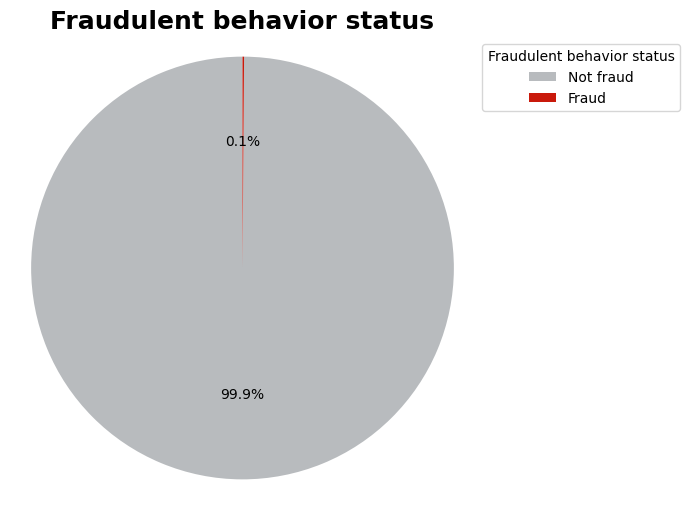

In [22]:
plt.figure(figsize=(6,6))

#Chart colors
colors = ['#B8BBBE', '#C9190B']

#Count the occurences of each category
counts = df['is_fraud'].value_counts()

#Plot bar chart
plt.pie(counts, colors=colors, autopct='%1.1f%%', startangle=90)

#Add labels and title
plt.title('Fraudulent behavior status', fontsize=18, weight='bold')
plt.axis('equal')
plt.legend(['Not fraud', 'Fraud'], title='Fraudulent behavior status', loc="upper left", bbox_to_anchor=(1, 1))

plt.show()

- There is a total of 4,261,904 transactions. In which, there are 4,255,870 valid transactions (99.9%), and 5,034 fraud cases (0.1%).
- The dataset is highly imbalanced.

### 5. Explore Variables of Interest

### Fraudulent transactions by categories

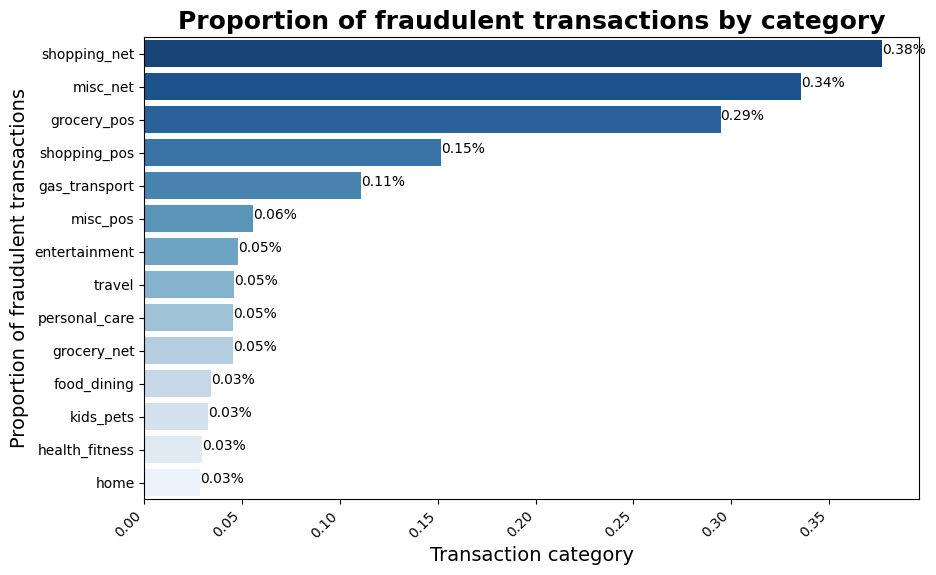

Top 5 categories with the highest occurrence of fraudulent transactions:
category
shopping_net     0.377183
misc_net         0.335616
grocery_pos      0.294514
shopping_pos     0.151570
gas_transport    0.110614
Name: count, dtype: float64


In [23]:
fraudulent_transactions = df[df['is_fraud'] == 1]

#Count total number of transactions by category
category_counts = df['category'].value_counts()

#Count number of fraudulent transactions by category
fraud_counts = fraudulent_transactions['category'].value_counts()

#Fraud proportion
fraud_proportion = ((fraud_counts/category_counts)*100).sort_values(ascending=False)

#Visualisation
plt.figure(figsize=(10,6))
sns.barplot(x=fraud_proportion.values, y=fraud_proportion.index, palette="Blues_r")
plt.xlabel('Transaction category', fontsize = 14)
plt.ylabel('Proportion of fraudulent transactions', fontsize = 14)
plt.title('Proportion of fraudulent transactions by category', fontsize = 18, weight = 'bold')
plt.xticks(rotation=45, ha='right')

y=fraud_proportion.values
for index, value in enumerate(y):
    plt.text(value, index, str(round(value,2))+'%')
plt.show()

top_categories = fraud_proportion.head(5)
print("Top 5 categories with the highest occurrence of fraudulent transactions:")
print(top_categories)

In [24]:
print(category_counts.sort_values(ascending=False))

category
shopping_pos      420268
home              403237
grocery_pos       401000
kids_pets         372055
gas_transport     365233
food_dining       320989
entertainment     312478
shopping_net      307013
personal_care     300730
misc_pos          281977
health_fitness    265986
misc_net          191290
grocery_net       181614
travel            137034
Name: count, dtype: int64


### Fraudulent transactions by jobs

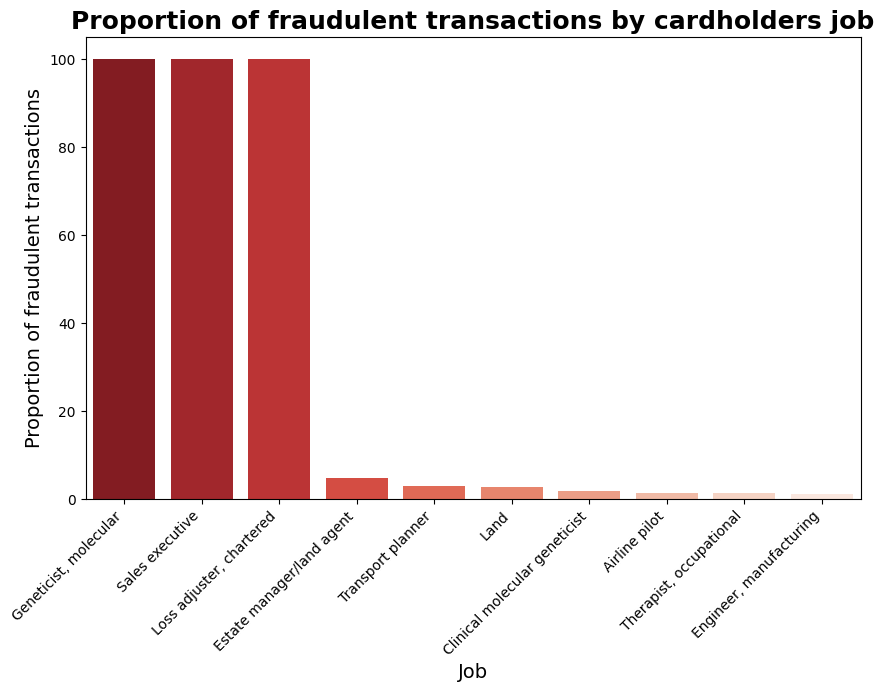

job
Teaching laboratory technician          53
Computer games developer                53
Agricultural consultant                 50
Accountant, chartered public finance    45
Clinical molecular geneticist           41
Name: count, dtype: int64
Top 5 jobs with the highest proportion of fraudulent transactions: 

Geneticist, molecular: 100.00%
Sales executive: 100.00%
Loss adjuster, chartered: 100.00%
Estate manager/land agent: 4.79%
Transport planner: 2.98%


In [25]:
fraudulent_transactions = df[df['is_fraud'] == 1]

#Count total number of transactions by job
job_counts = df['job'].value_counts()

#Count number of fraudulent transactions by job
fraud_counts = fraudulent_transactions['job'].value_counts()

#Fraud proportion
fraud_proportion = ((fraud_counts/job_counts)*100).sort_values(ascending=False)

# Top 10 jobs with highest fraud proportion
top_10_jobs = fraud_proportion.head(10)

#Visualisation
plt.figure(figsize=(10,6))
sns.barplot(y=top_10_jobs.values, x=top_10_jobs.index, palette="Reds_r")
plt.xlabel('Job', fontsize = 14)
plt.ylabel('Proportion of fraudulent transactions', fontsize = 14)
plt.title('Proportion of fraudulent transactions by cardholders job', fontsize = 18, weight = 'bold')
plt.xticks(rotation=45, ha='right')

plt.show()

print(fraud_counts.head(5))

print("Top 5 jobs with the highest proportion of fraudulent transactions: \n")
for job, proportion in fraud_proportion.head(5).items():
    print(f"{job}: {proportion:.2f}%")

In [26]:
fraud_counts = fraudulent_transactions['job'].value_counts().sort_values(ascending=False)
fraud_counts_list = fraud_counts.iloc[:5]
fraud_counts_list

,count
job,
Teaching laboratory technician,53
Computer games developer,53
Agricultural consultant,50
"Accountant, chartered public finance",45
Clinical molecular geneticist,41


In [27]:
job_count_computer_games_developer = df[df['job'] == 'Computer games developer'].shape[0]
job_count_teaching_laboratory_technician = df[df['job'] == 'Teaching laboratory technician'].shape[0]
job_count_agricultural_consultant = df[df['job'] == 'Agricultural consultant'].shape[0]
job_count_accountant_chartered_public_finance = df[df['job'] == 'Accountant, chartered public finance'].shape[0]
job_count_clinical_molecular_geneticist = df[df['job'] == 'Clinical molecular geneticist'].shape[0]

print(job_count_computer_games_developer)
print(job_count_teaching_laboratory_technician)
print(job_count_agricultural_consultant)
print(job_count_accountant_chartered_public_finance)
print(job_count_clinical_molecular_geneticist)

33859
14251
13121
26965
2216


In [28]:
fraudulent_transactions = df[df['is_fraud'] == 1]
fraudulent_transactions[fraudulent_transactions['job'] == 'Estate manager/land agent'].count()

,0
card holder,18
credit card number,18
account number,18
dob,18
age,18
age group,18
job,18
street,18
zipcode,18
city,18


### Fraudulent transactions by months

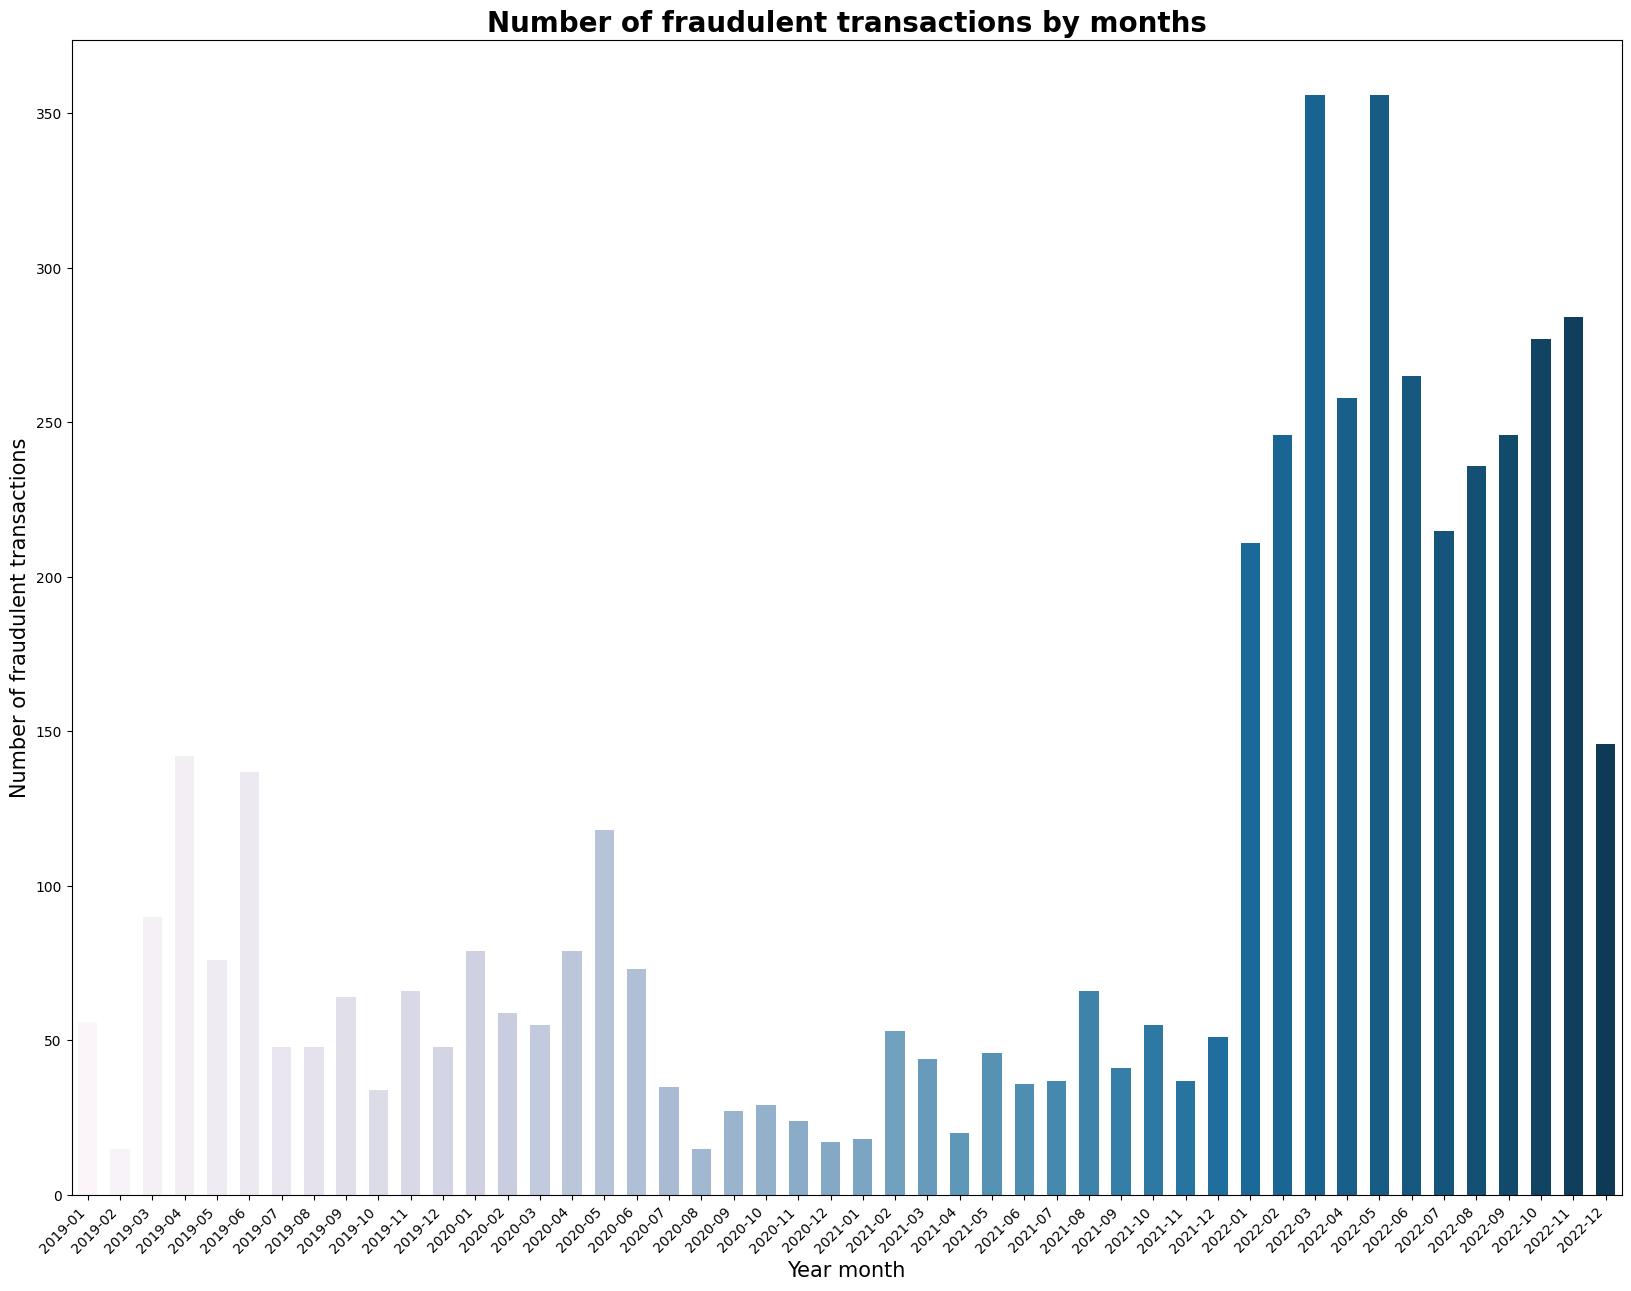

In [29]:
fraudulent_transactions = df[df['is_fraud'] == 1]
frauds_by_year_month = fraudulent_transactions['trans_year_month']

# Sort
frauds_by_year_month_sorted = frauds_by_year_month.sort_values()

# Visualisation
plt.figure(figsize=(20,15))
sns.countplot(x=frauds_by_year_month_sorted, order=frauds_by_year_month_sorted.unique(), palette = 'PuBu',  width=0.6)
plt.xlabel('Year month', fontsize = 15)
plt.ylabel('Number of fraudulent transactions', fontsize = 15)
plt.title('Number of fraudulent transactions by months', fontsize = 20, weight = 'bold')
plt.xticks(rotation=45, ha='right')
plt.show()

March 2022 and May 2022 are months with the highest number of fraud transactions

### Fraudulent transactions by age group

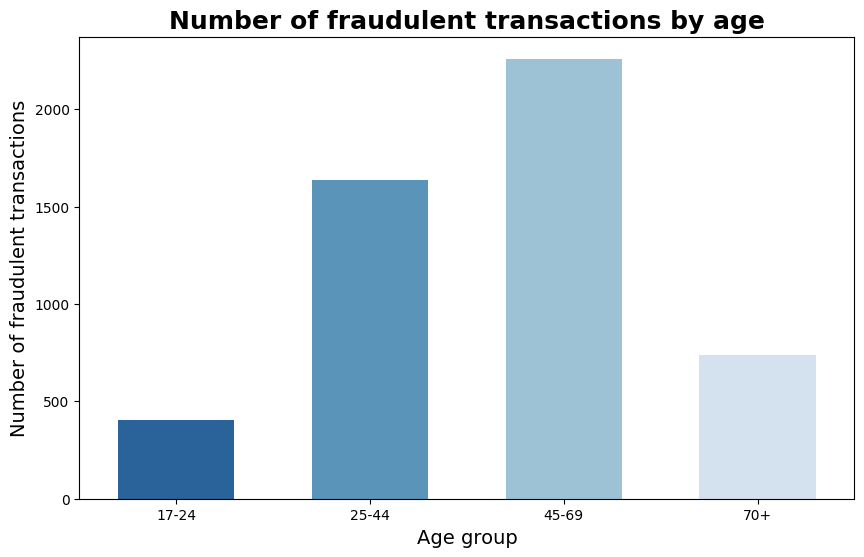

In [30]:
fraudulent_transactions = df[df['is_fraud'] == 1]

# Count the number of fraudulent transactions by age
frauds_by_age = fraudulent_transactions['age group'].value_counts()


# Visualization
plt.figure(figsize=(10,6))
order = ['17-24', '25-44', '45-69', '70+']
sns.countplot(x=fraudulent_transactions['age group'], order=order, palette='Blues_r', width=0.6)
plt.xlabel('Age group', fontsize=14)
plt.ylabel('Number of fraudulent transactions', fontsize=14)
plt.title('Number of fraudulent transactions by age', fontsize=18, weight='bold')
plt.show()

### Fraudulent transactions by state

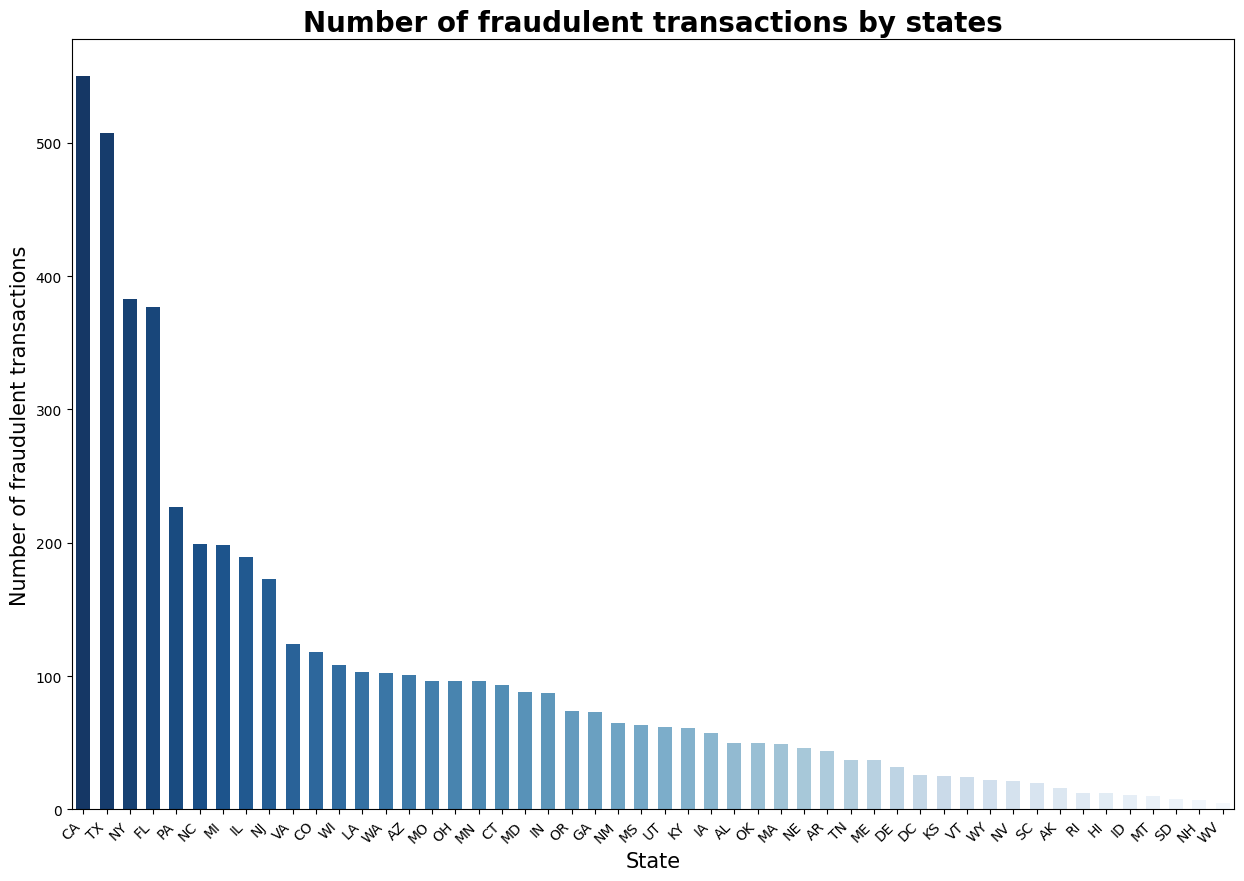

In [31]:
fraudulent_transactions = df[df['is_fraud'] == 1]

# Count the number of fraudulent transactions by state
frauds_by_state = fraudulent_transactions['state'].value_counts()

# Sort states by the number of fraudulent transactions in descending order
frauds_by_state_sorted = frauds_by_state.sort_values(ascending=False)

# Visualization
plt.figure(figsize=(15,10))
sns.countplot(x=fraudulent_transactions['state'], palette='Blues_r', order=frauds_by_state_sorted.index, width=0.6)
plt.xlabel('State', fontsize=15)
plt.ylabel('Number of fraudulent transactions', fontsize=15)
plt.title('Number of fraudulent transactions by states', fontsize=20, weight='bold')
plt.xticks(rotation=45, ha='right')
plt.show()

### 6. Data processing

In [32]:
df.duplicated().sum()

0

In [33]:
df.isnull().sum()

,0
card holder,0
credit card number,0
account number,0
dob,0
age,0
age group,0
job,0
street,0
zipcode,0
city,0


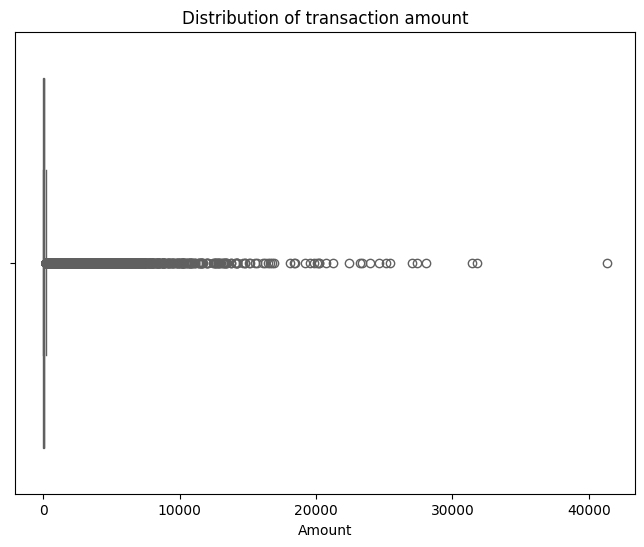

In [34]:
#Box plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='amount', palette='Blues')
plt.title('Distribution of transaction amount')
plt.xlabel('Amount')
plt.show()

### Handle outliers with Isolation Forest

In [35]:
from sklearn.ensemble import IsolationForest

In [36]:
outliers = pd.DataFrame(df, columns=['amount'])

isolation_forest = IsolationForest(n_estimators=200, max_samples='auto', contamination=float(0.1), max_features=1.0)
isolation_forest.fit(outliers)

IsolationForest(contamination=0.1, n_estimators=200)

In [37]:
#Add scores and anomaly column
scores = isolation_forest.decision_function(outliers)
anomaly = isolation_forest.predict(outliers)

outliers['scores'] = scores
outliers['anomaly'] = anomaly

outliers.head(10)

,amount,scores,anomaly
0,69.12,0.101658,1
1,68.11,0.101782,1
2,40.35,0.085673,1
3,96.22,0.075588,1
4,71.89,0.103362,1
5,73.58,0.105158,1
6,57.69,0.101037,1
7,74.27,0.101403,1
8,48.09,0.096429,1
9,75.84,0.099499,1


In [38]:
anomaly = outliers.loc[outliers['anomaly'] == -1]
anomaly_index = list(anomaly.index)
print('Total number of outliers is: ', len(anomaly))

Total number of outliers is:  425269


In [39]:
anomaly.head(10)

,amount,scores,anomaly
332,153.22,-0.007376,-1
382,147.62,-0.001657,-1
432,155.16,-0.007197,-1
531,152.12,-0.004582,-1
546,143.23,-0.000084,-1
638,209.32,-0.029477,-1
645,222.40,-0.053387,-1
669,198.01,-0.014738,-1
675,258.04,-0.116624,-1
684,222.16,-0.051521,-1


In [40]:
#Drop outliers
df=df.drop(anomaly_index, axis=0).reset_index(drop=True)

In [41]:
df.shape

(3835635, 18)

### Encoding

In [42]:
!pip install category_encoders

In [43]:
# Import package
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder

In [44]:
# Encode age group
label_encoder = LabelEncoder()

df['age group'] = label_encoder.fit_transform(df['age group'])

In [45]:
# Encode other columns
cols = ['card holder', 'credit card number', 'account number',  'age', 'job',
        'street', 'zipcode', 'city', 'state', 'population of city',
        'transaction number', 'category', 'merchant']

# Initialize LabelEncoder
target_encoder = TargetEncoder(cols = cols)

df['is_fraud'] = df['is_fraud'].astype('float')

# Apply label encoding to categorical columns
df[cols] = target_encoder.fit_transform(df[cols], df['is_fraud'])

### Split dataset

In [46]:
from sklearn.model_selection import train_test_split

In [47]:
df = df.drop(columns = ['dob', 'trans_year_month'], axis=1)

In [48]:
X = df.drop(columns=['is_fraud'])
y = df['is_fraud']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

In [49]:
print("X_train shape: ", X_train.shape)
print("X_val shape: ", X_val.shape)
print("X_test shape: ", X_test.shape)

print("y_train shape: ", y_train.shape)
print("y_val shape: ", y_val.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (2454806, 15)
X_val shape:  (613702, 15)
X_test shape:  (767127, 15)
y_train shape:  (2454806,)
y_val shape:  (613702,)
y_test shape:  (767127,)


### Handle imbalanced data

In [50]:
#Import package
from imblearn.over_sampling import SMOTE

In [51]:
#Astype
y_train = y_train.astype(int)
y_val = y_val.astype(int)
y_test = y_test.astype(int)

In [52]:
smote = SMOTE(random_state = 42)

In [53]:
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_val_resampled, y_val_resampled = smote.fit_resample(X_val, y_val)
X_test_resampled, y_test_resampled = smote.fit_resample(X_test, y_test)

## 7. Use cases

### Feature selection

In [54]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

In [55]:
feature_selection = SelectKBest(mutual_info_classif, k=8)

In [56]:
feature_selection.fit(X_train_resampled, y_train_resampled)
X_train_selected = feature_selection.transform(X_train_resampled)

In [57]:
feature_selection.get_feature_names_out()

array(['card holder', 'credit card number', 'account number', 'street',
       'zipcode', 'city', 'population of city', 'merchant'], dtype=object)

### Baseline model

In [58]:
y_mode = y.mode()

In [59]:
y_base = np.full(y_train.shape, y_mode)

In [60]:
y_base = y_base.astype('int64')

In [61]:
#Accuracy score on y base
print('Accuracy score on y base:', accuracy_score(y_train, y_base))

Accuracy score on y base: 0.9997009947018216


### KNN

In [62]:
# Import KNN
from sklearn.neighbors import KNeighborsClassifier

# Import gridsearch for hyperparameter
from sklearn.model_selection import GridSearchCV

In [63]:
# Initialize param grid
params_grid = {
    'n_neighbors': [5, 10],
    'weights': ['uniform']
}

In [64]:
model = KNeighborsClassifier()

In [65]:
GridSearch = GridSearchCV(model, params_grid, cv=5)

In [66]:
GridSearch.fit(X_train_selected, y_train_resampled)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [5, 10], 'weights': ['uniform']})

In [67]:
#Print best hyperparameter and best score
print("Best hyperparameters:", GridSearch.best_params_)
print("Best score:", GridSearch.best_score_)

Best hyperparameters: {'n_neighbors': 5, 'weights': 'uniform'}
Best score: 0.9929568080853542


In [68]:
pd.DataFrame(GridSearch.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,15.095953,0.545439,541.059445,5.645144,5,uniform,"{'n_neighbors': 5, 'weights': 'uniform'}",0.992796,0.993217,0.993077,0.992874,0.992820,0.992957,0.000164,1
1,14.497886,0.298288,543.900121,5.715780,10,uniform,"{'n_neighbors': 10, 'weights': 'uniform'}",0.991506,0.991805,0.991764,0.991440,0.991387,0.991580,0.000172,2


### Evaluate model

In [ ]:
y_train_preds = GridSearch.predict(X_train_selected)

In [ ]:
f1 = f1_score(y_train_resampled, y_train_preds)
precision = precision_score(y_train_resampled, y_train_preds)
recall = recall_score(y_train_resampled, y_train_preds)
accuracy = accuracy_score(y_train_resampled, y_train_preds)

print("F1 score: ", f1)
print("Precision score: ", precision)
print("Recall score: ", recall)
print("Accuracy: ", accuracy)

In [ ]:
# Evaluate on validation set
feature_selection.fit(X_val_resampled, y_val_resampled)
X_val_selected = feature_selection.transform(X_val_resampled)
y_val_preds = GridSearch.predict(X_val_selected)

In [ ]:
f1 = f1_score(y_val_resampled, y_val_preds)
precision = precision_score(y_val_resampled, y_val_preds)
recall = recall_score(y_val_resampled, y_val_preds)
accuracy = accuracy_score(y_val_resampled, y_val_preds)

print("F1 score: ", f1)
print("Precision score: ", precision)
print("Recall score: ", recall)
print("Accuracy: ", accuracy)

In [ ]:
# Evaluate on test set
feature_selection.fit(X_test_resampled, y_test_resampled)
X_test_selected = feature_selection.transform(X_test_resampled)
y_test_preds = GridSearch.predict(X_test_selected)

In [ ]:
f1 = f1_score(y_test_resampled, y_test_preds)
precision = precision_score(y_test_resampled, y_test_preds)
recall = recall_score(y_test_resampled, y_test_preds)
accuracy = accuracy_score(y_test_resampled, y_test_preds)

print("F1 score: ", f1)
print("Precision score: ", precision)
print("Recall score: ", recall)
print("Accuracy: ", accuracy)

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test_resampled, y_test_preds)

# Plot confusion matrix as heatmap
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix analysis with KNN algorithm', fontsize=14, weight='bold')
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Set tick labels
tick_labels = ['Fraudulent', 'Legitimate']
plt.xticks(ticks=[0.5, 1.5], labels=tick_labels)
plt.yticks(ticks=[0.5, 1.5], labels=tick_labels)

plt.tight_layout()
plt.show()

In [ ]:
#Calculate confusion matrix
true_negative, false_positive, false_negative, true_positive = confusion_matrix(y_test_resampled, y_test_preds).ravel()

# print the results
print("True negatives:", true_negative)
print("False positives:", false_positive)
print("False negatives:", false_negative)
print("True positives:", true_positive)

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [ ]:
best_model = GridSearch.best_estimator_

In [ ]:
y_pred_prob = best_model.predict_proba(X_test_selected)[:, 1]

In [ ]:
roc_auc = roc_auc_score(y_test_resampled, y_pred_prob)
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_resampled, y_pred_prob, pos_label=1)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='K-Nearest Neighbors (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()